试用PyTorch实现了简化版的TiDE, 实在是被惊艳到了:
1. PyTorch实现起DL模型来真实太简单,太方便,太易用了! 感谢创建和维护者!
2. TiDE的拟合太厉害了! 即便只是简化版!
3. 就从这里开始吧!....

In [1]:
import torch, time
import numpy as np
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = False
plt.rcParams['axes.unicode_minus'] = False  # Unicode 负号的处理
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或其他支持广泛 Unicode 的字体

# 辅助函数，用于打印时间戳和状态信息
def get_time(): return time.strftime("\n[%C%y-%m-%d =%W=%w= %H:%M:%S]", time.localtime())
def ready(txt=''): print(get_time() + f' {txt}: Ready2Go')
def done(txt=''):  print(get_time() + f' {txt}: GetThere')
#


class TideBlock(nn.Module):
    """
    TideBlock 类实现了一个基本的神经网络块，包括两个线性层、残差连接、dropout 和层归一化
    """
    def __init__(self, input_dim, output_dim, hidden_dim, dropout_rate=0.0, use_layernorm=True):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.use_layernorm = use_layernorm
        self.lin_a = nn.Linear(input_dim, hidden_dim)
        self.lin_b = nn.Linear(hidden_dim, output_dim)
        self.lin_res = nn.Linear(input_dim, output_dim)  # 残差连接
        self.dropout = nn.Dropout(p=self.dropout_rate)
        self.layer_norm = nn.LayerNorm(output_dim)

    def forward(self, x):
        branch1 = torch.relu(self.lin_a(x))
        branch1 = self.dropout(self.lin_b(branch1))
        branch2 = torch.relu(self.lin_res(x))  # 残差分支
        out = branch1 + branch2
        return self.layer_norm(out) if self.use_layernorm else out

done('TideBlock')

def make_coder(input_dim, output_dim, intmlp_dims, dropout_rate=0.0, use_layernorm=True):
    """
    构建一个编码器或解码器，由多个 TideBlock 组成
    intmlp_dims: 中间层的维度列表
    """
    def get_hidden_dim(input_dim, output_dim):
        # 计算相关MLP的隐藏层维度，使用对数尺度
        Linp_dim = np.log2(input_dim)
        Lout_dim = np.log2(output_dim)
        return int(2 ** np.round(Linp_dim/2 + Lout_dim/2))

    th_dims = [input_dim] + intmlp_dims + [output_dim]
    layers = [TideBlock(th_dims[i-1], th_dims[i], get_hidden_dim(th_dims[i-1], th_dims[i]), dropout_rate, use_layernorm)
              for i in range(1, len(th_dims))]
    return nn.Sequential(*layers)  # 使用 * 解包列表，创建 Sequential 模型

class TideLite(nn.Module):
    """ 简化版本的Tide模型，没有考虑静态特性和协变量 """

    def __init__(self, model_config, dropout_rate=0.0, use_layernorm=True):
        super().__init__()
        self.seq_len = model_config['seq_len']  # 输入序列长度
        self.pred_len = model_config['pred_len']  # 预测长度
        self.dim_en2de = model_config['dim_en2de']  # 编码器到解码器的维度
        self.dim_de2st = model_config['dim_de2st']  # 解码器到步进器的维度
        self.encoder_intmlp_dims = model_config['encoder_intmlp_dims']  # 编码器中间层维度
        self.decoder_intmlp_dims = model_config['decoder_intmlp_dims']  # 解码器中间层维度
        self.stepper_hidden_dim = model_config['stepper_hidden_dim']  # 步进器隐藏层维度

        # 构建编码器、解码器和步进器
        self.encoder = make_coder(self.seq_len, self.dim_en2de, self.encoder_intmlp_dims, dropout_rate, use_layernorm)
        self.decoder = make_coder(self.dim_en2de, self.dim_de2st, self.decoder_intmlp_dims, dropout_rate, use_layernorm)
        self.stepper = TideBlock(self.dim_de2st, self.pred_len, self.stepper_hidden_dim, dropout_rate, use_layernorm)
        self.lin_res = nn.Linear(self.seq_len, self.pred_len)  # 残差连接

    def forward(self, x):
        # 确保 x 的形状是 (batch_size, seq_len)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        stepped = self.stepper(decoded)
        res = self.lin_res(x)  # 残差连接
        return res + stepped

done('model')


# 生成模拟数据
'''
def generate_data(num_samples, seq_len, pred_len):
    total_len = seq_len + pred_len
    t = np.linspace(0, 1, total_len)
    data = np.sin(2 * np.pi * 10 * t) + np.random.normal(0, 0.1, t.shape)

    X = np.zeros((num_samples, seq_len), dtype=np.float32)
    y = np.zeros((num_samples, pred_len), dtype=np.float32)

    for i in range(num_samples):
        start = np.random.randint(0, len(data) - total_len + 1)
        X[i] = data[start:start+seq_len]
        y[i] = data[start+seq_len:start+total_len]

    return torch.as_tensor(X), torch.as_tensor(y)
'''


def generate_data(num_samples, seq_len, pred_len):
    total_len = seq_len + pred_len
    t = np.linspace(0, 10, total_len)  # 增加时间范围
    data = (0.6 * np.sin(2 * np.pi * 1 * t) +    # 中频成分
            0.3 * np.sin(2 * np.pi * 0.1 * t) +  # 添加低频成分
            0.3 * np.sin(2 * np.pi * 10 * t) +   # 添加高频成分
            0.1 * t +                            # 添加线性趋势
            0.2 * np.random.normal(0, 1, t.shape) # 增加噪声
    )
    X = np.zeros((num_samples, seq_len))
    y = np.zeros((num_samples, pred_len))
    
    for i in range(num_samples):
        start = np.random.randint(0, len(data) - total_len + 1)
        X[i] = data[start:start+seq_len]
        y[i] = data[start+seq_len:start+total_len]
    
    return torch.FloatTensor(X), torch.FloatTensor(y)


# 训练函数
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


# 评估函数
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            total_loss += loss.item()
    return total_loss / len(test_loader)


# ===

ready("主程序")

# 设置随机种子
seed = 137
torch.manual_seed(seed)
np.random.seed(seed)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 模型配置
model_config = {
    'seq_len': 100,
    'pred_len': 20,
    'dim_en2de': 128,
    'dim_de2st': 64,
    'encoder_intmlp_dims': [64, 128],
    'decoder_intmlp_dims': [64, 32],
    'stepper_hidden_dim': 32,
}

# 生成数据
num_samples = 20000
X, y = generate_data(num_samples, model_config['seq_len'], model_config['pred_len'])

# 划分训练集和测试集
train_size = int(0.7 * num_samples)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 创建数据加载器
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 初始化模型
model = TideLite(model_config, dropout_rate=0.1, use_layernorm=True).to(device)
# print(model)

# 设置优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 训练模型
num_epochs = 100
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    test_loss = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if (epoch + 1) % 10 == 0: print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')



[2024-09-11 =37=3= 14:20:12] TideBlock: GetThere

[2024-09-11 =37=3= 14:20:12] model: GetThere

[2024-09-11 =37=3= 14:20:12] 主程序: Ready2Go
Epoch [10/100], Train Loss: 0.000004, Test Loss: 0.000009
Epoch [20/100], Train Loss: 0.000008, Test Loss: 0.000010
Epoch [30/100], Train Loss: 0.000001, Test Loss: 0.000001
Epoch [40/100], Train Loss: 0.000005, Test Loss: 0.000001
Epoch [50/100], Train Loss: 0.000005, Test Loss: 0.000001
Epoch [60/100], Train Loss: 0.000007, Test Loss: 0.000006
Epoch [70/100], Train Loss: 0.000004, Test Loss: 0.000001
Epoch [80/100], Train Loss: 0.000004, Test Loss: 0.000002
Epoch [90/100], Train Loss: 0.000004, Test Loss: 0.000003
Epoch [100/100], Train Loss: 0.000004, Test Loss: 0.000001


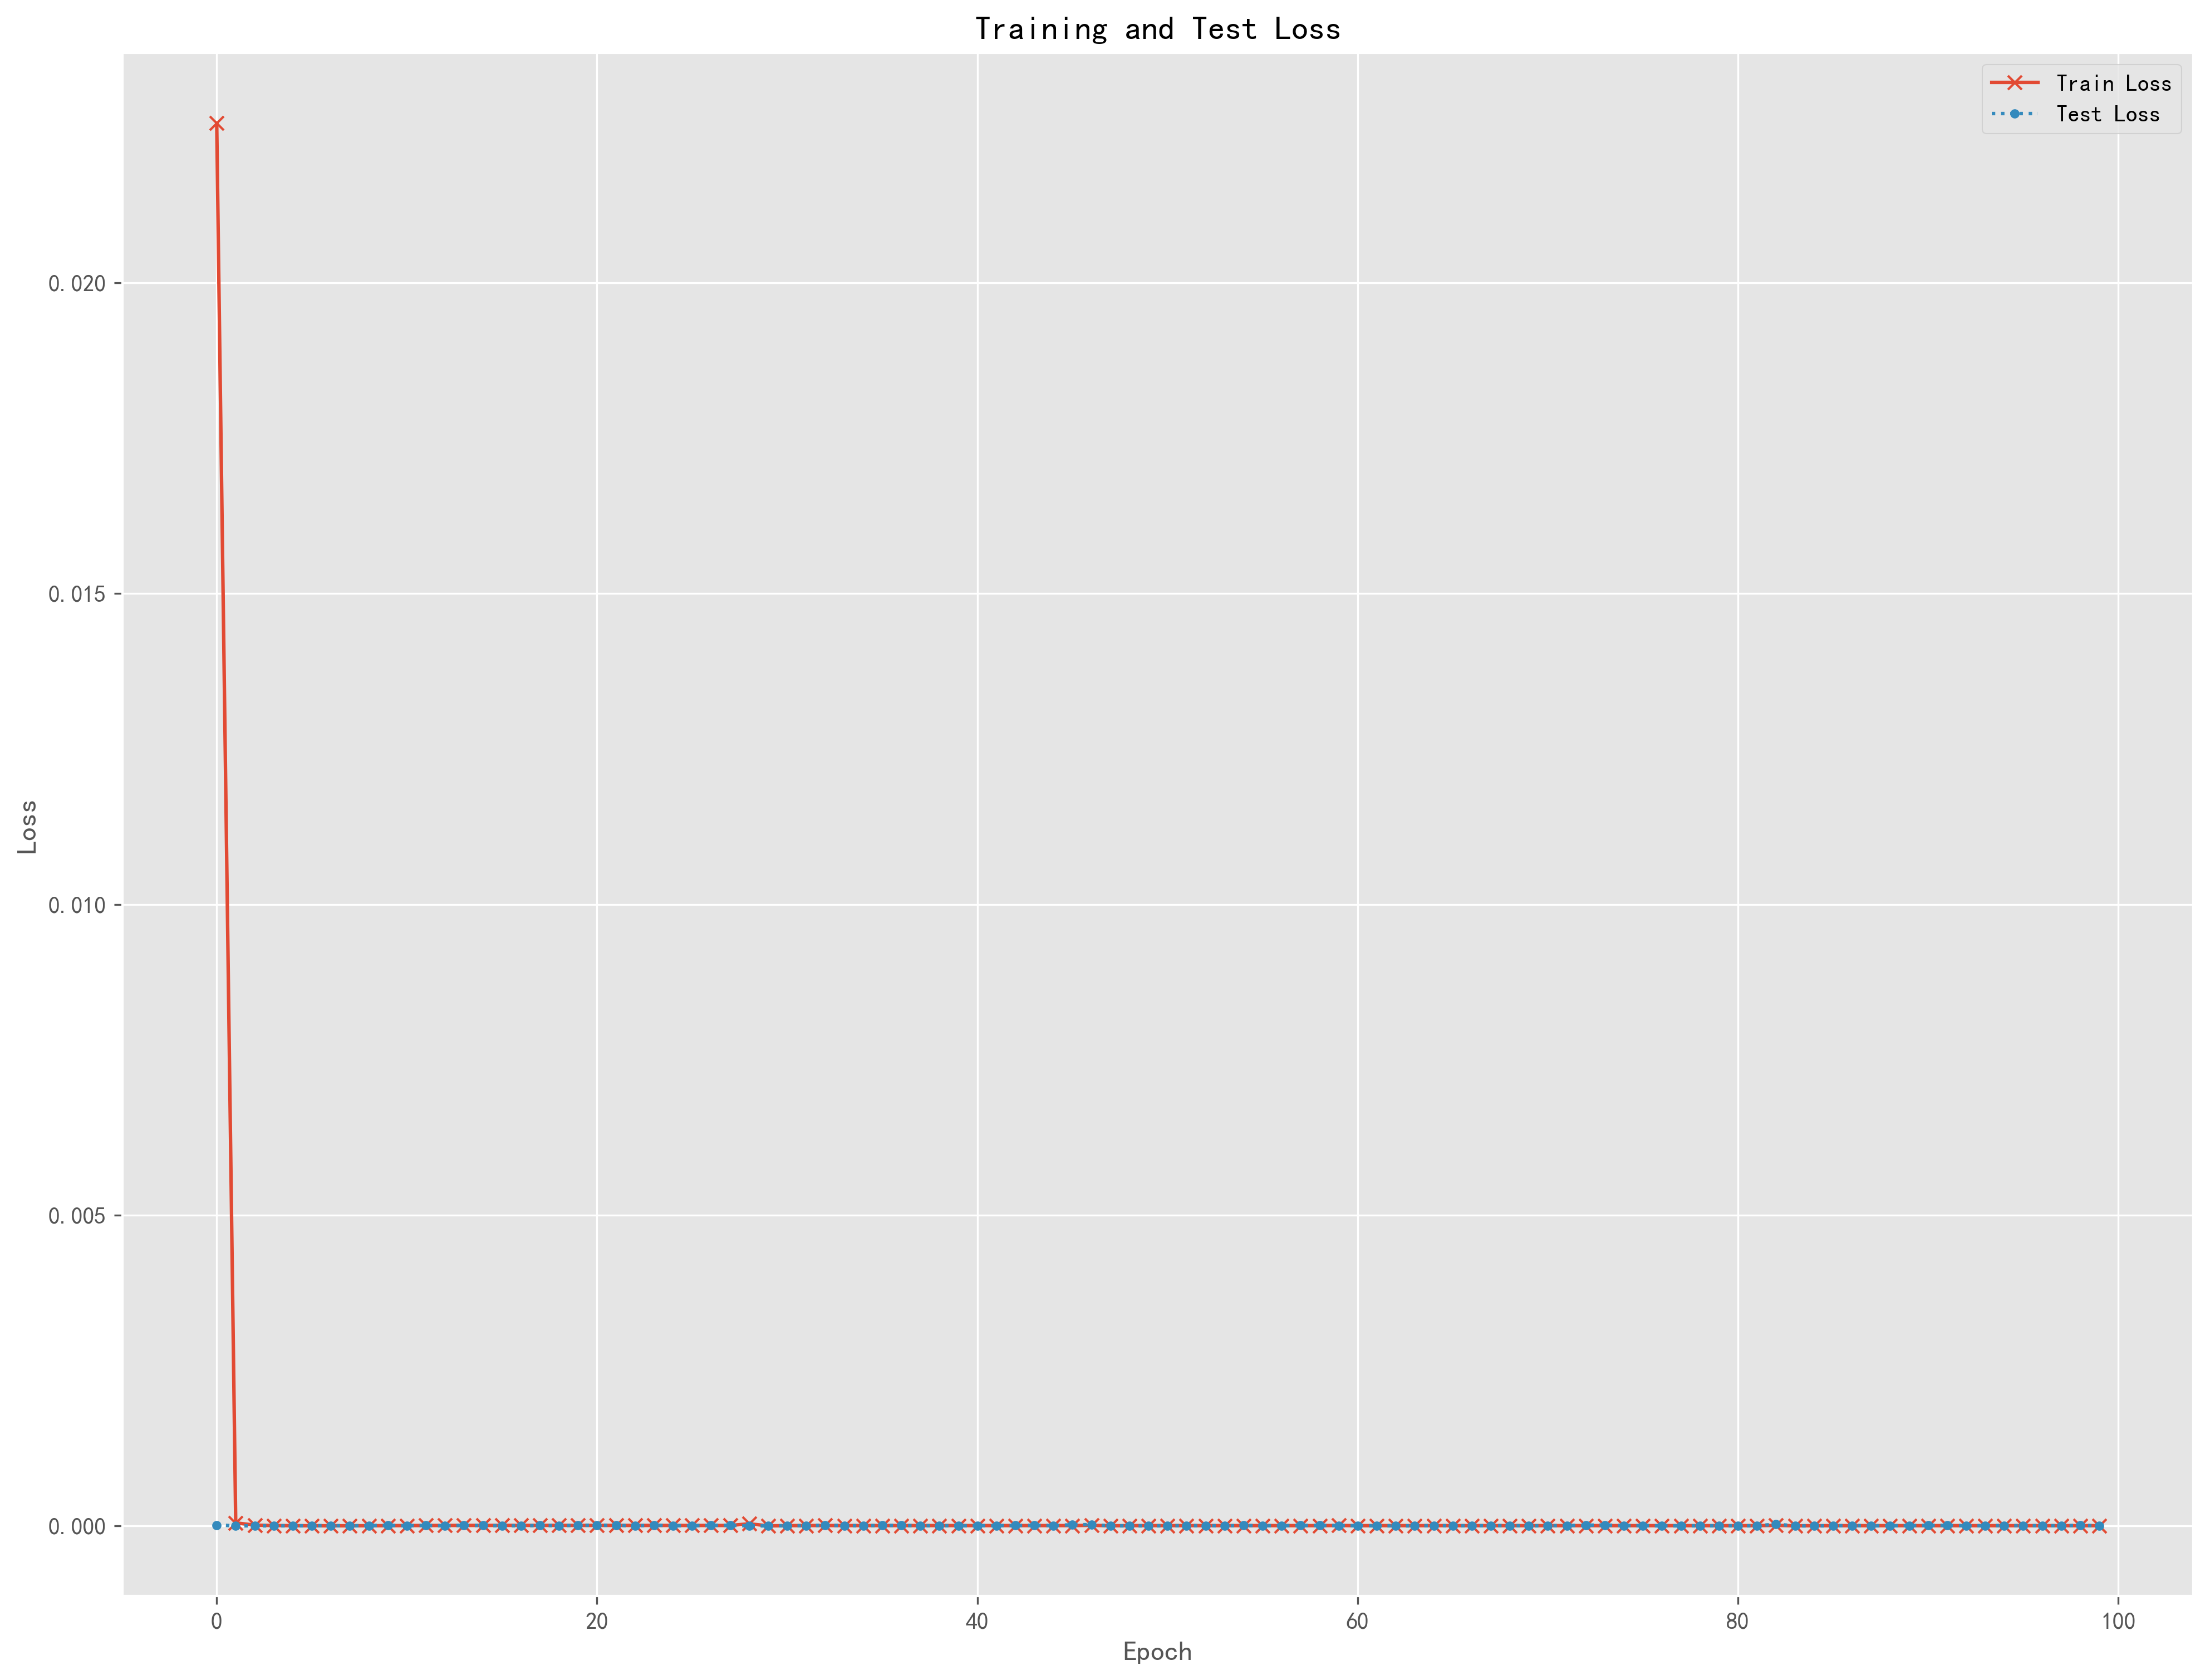

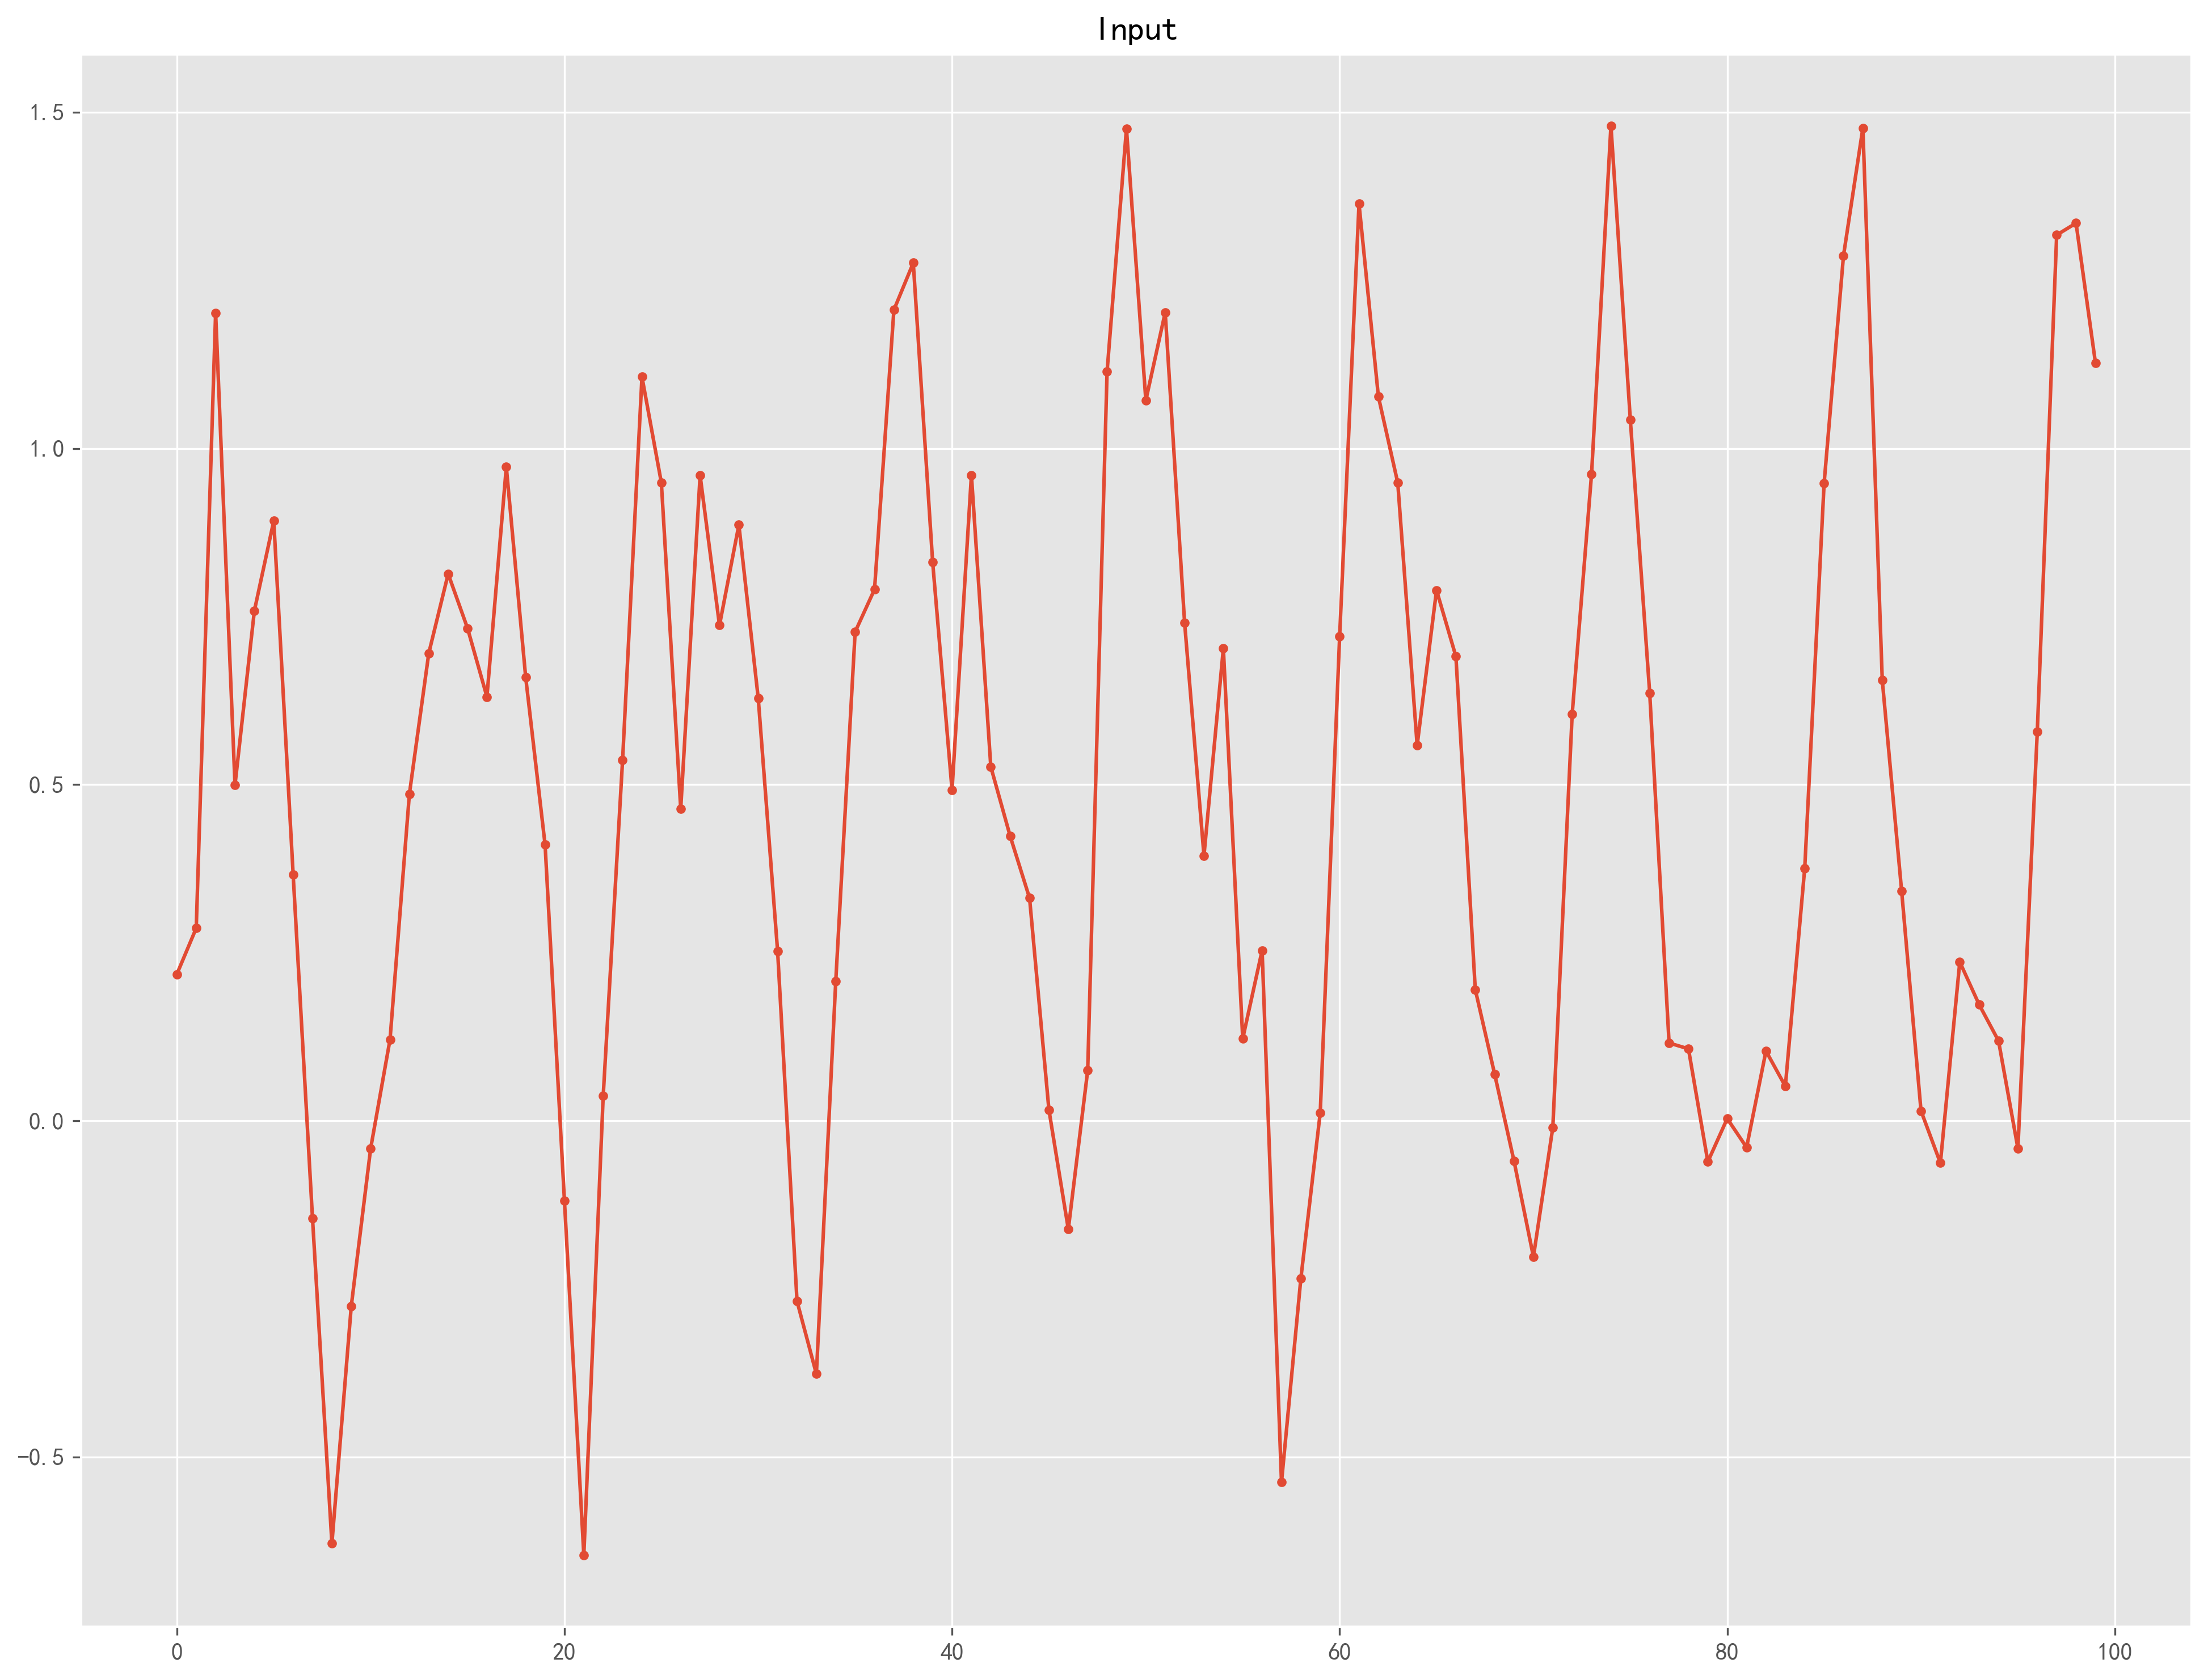

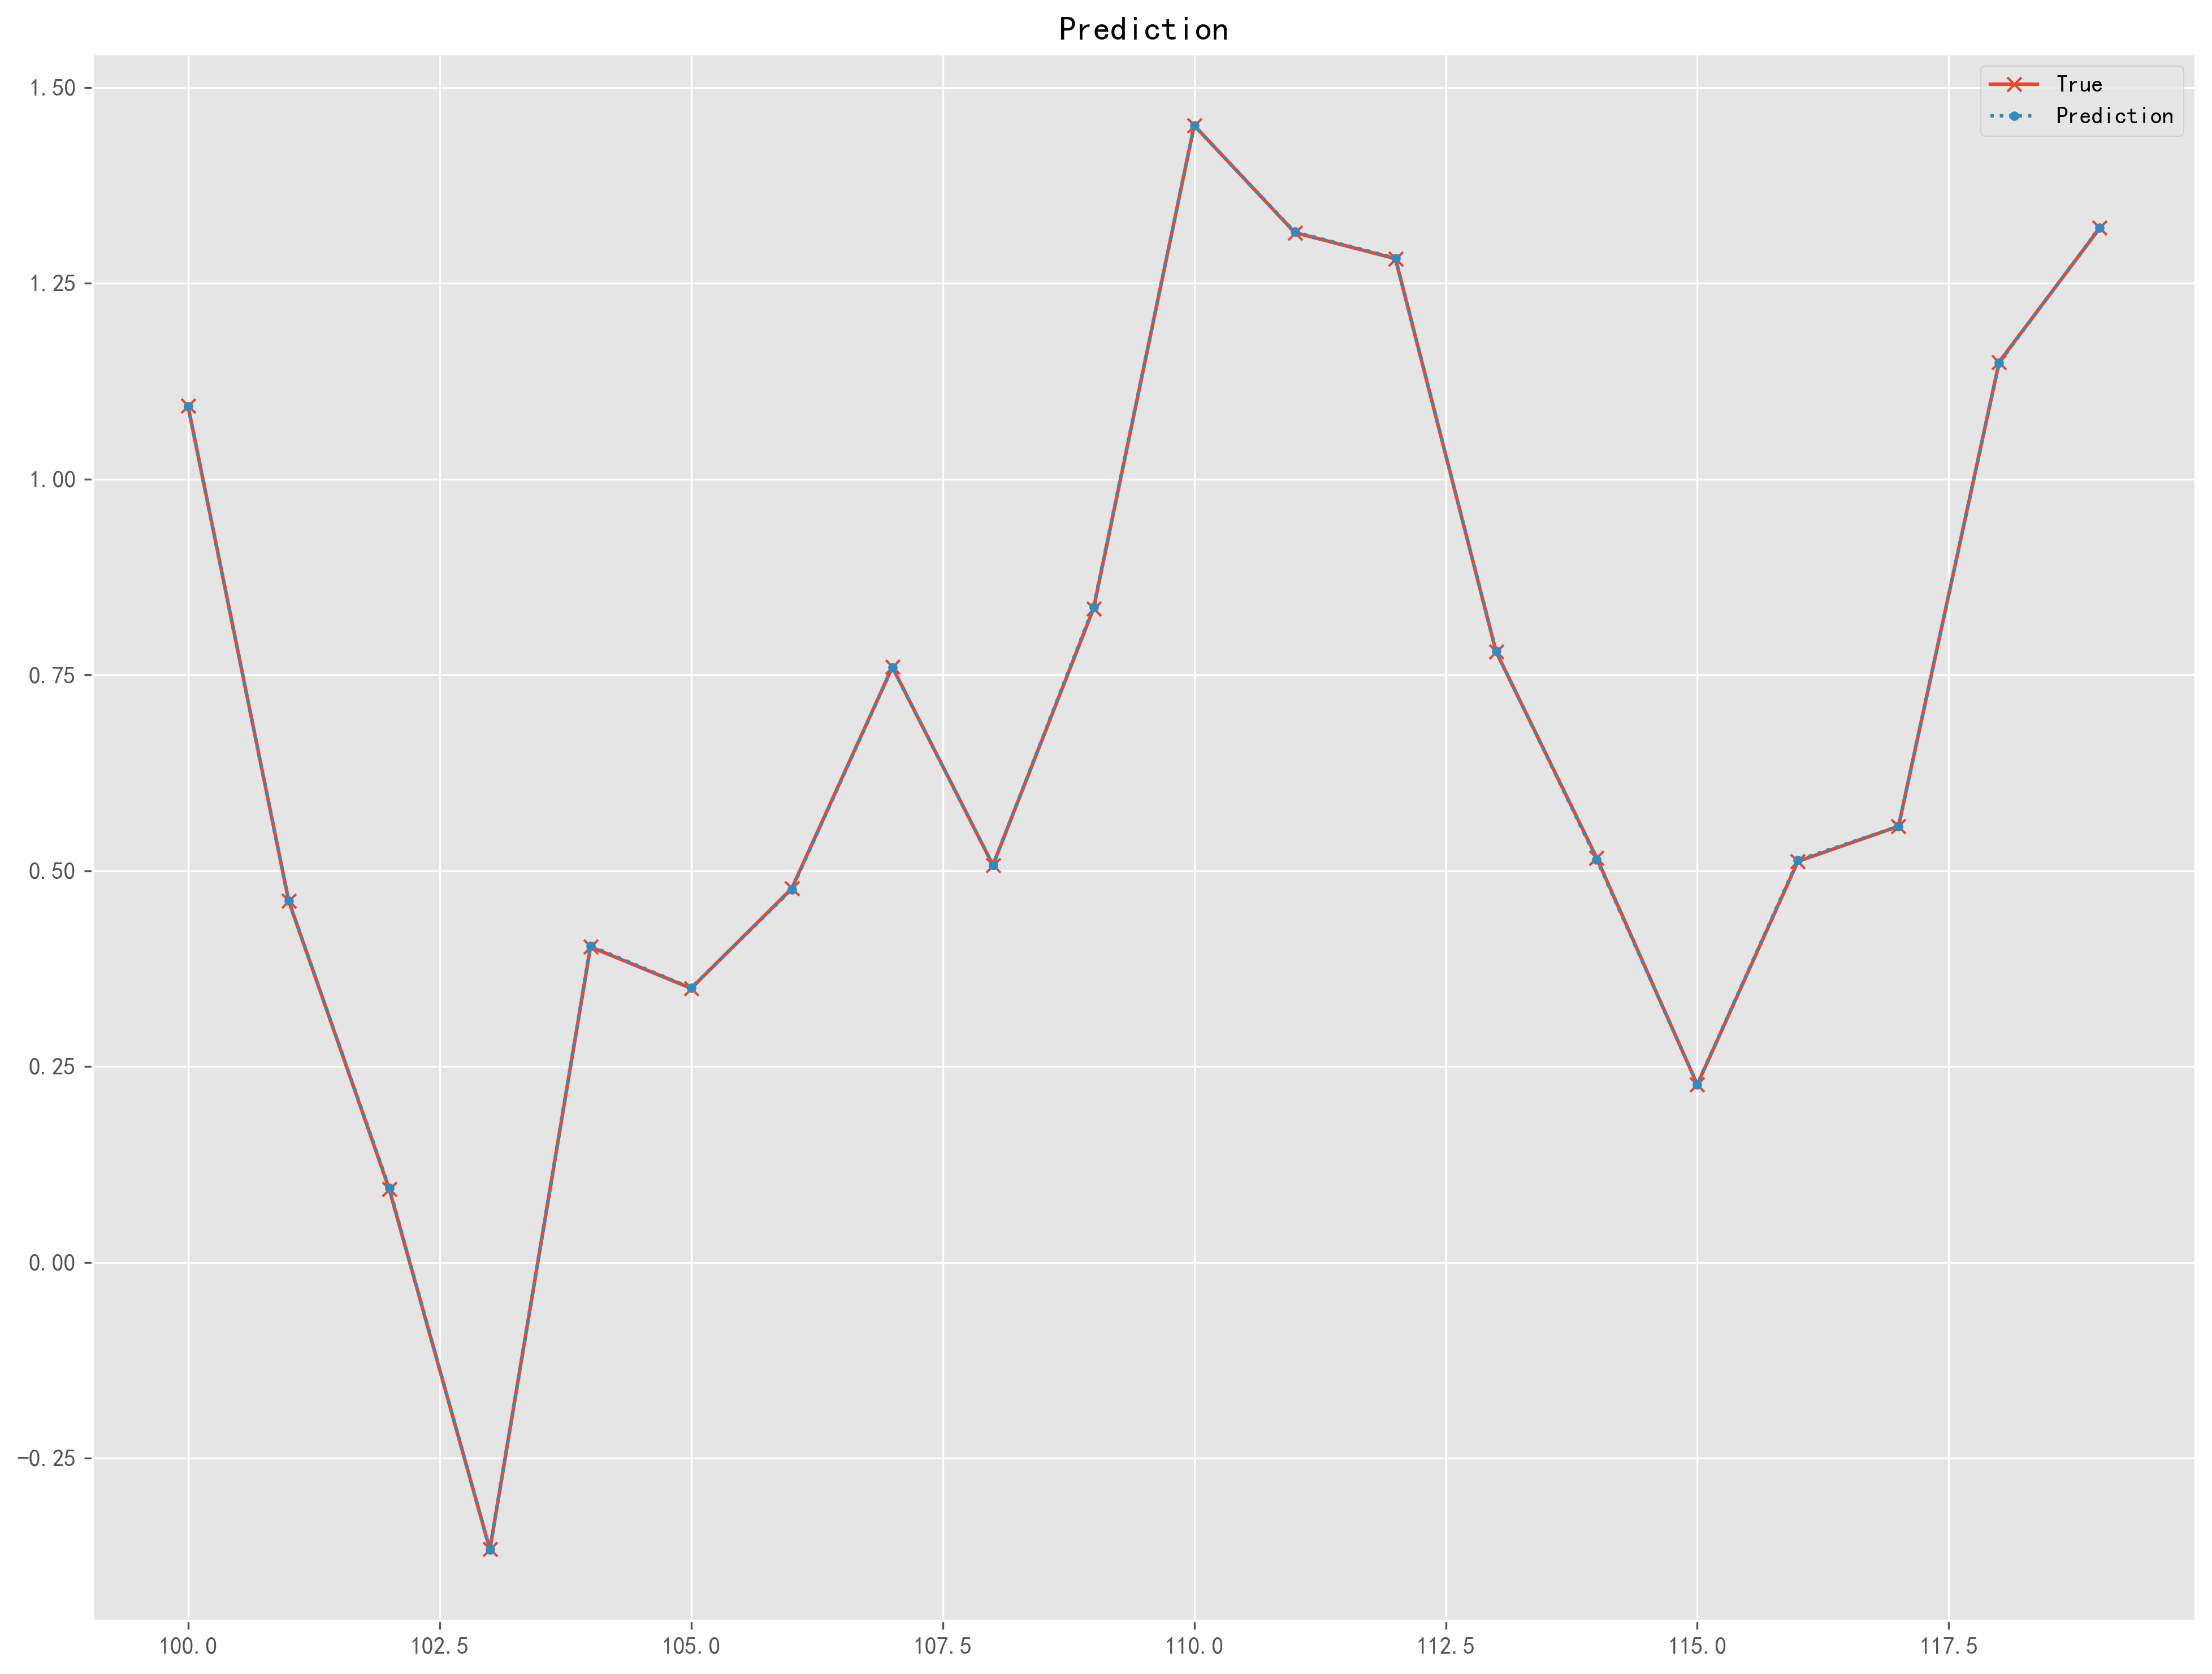


[2024-09-11 =37=3= 14:44:42] 主程序: GetThere
delta(true-pred): [ 4.8279762e-04  2.0715594e-04 -1.6978160e-03  2.7275085e-04
 -1.2080967e-03 -4.7940016e-04  1.1979043e-03  4.7880411e-04
 -8.2194805e-05 -2.0770431e-03  4.2426586e-04 -7.6770782e-04
 -7.0261955e-04 -6.9791079e-04  1.9905567e-03 -4.5369565e-04
 -1.5131831e-03  2.5987625e-05  8.3351135e-04 -3.5822392e-04]


In [2]:
# 绘制损失曲线
# plt.figure(figsize=(10, 5))
# plt.semilogy(train_losses, label='Train Loss')
# plt.semilogy(test_losses, label='Test Loss')
plt.plot(train_losses, 'x-', label='Train Loss')
plt.plot(test_losses, '.:', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

# 预测并可视化结果
model.eval()
torch.set_grad_enabled(False) # with torch.no_grad():
X_sample, y_sample = X_test[:1].to(device), y_test[:1].to(device)
prediction = model(X_sample)
torch.set_grad_enabled(True)

# plt.figure(figsize=(12, 6))
plt.plot(range(model_config['seq_len']), X_sample[0].cpu().numpy(), '.-', label='Input Sequence')
plt.title('Input')
plt.show()
plt.plot(range(model_config['seq_len'], model_config['seq_len'] + model_config['pred_len']), y_sample[0].cpu().numpy(), 'x-', label='True')
plt.plot(range(model_config['seq_len'], model_config['seq_len'] + model_config['pred_len']), prediction[0].cpu().numpy(), '.:', label='Prediction')
plt.legend()
plt.title('Prediction')
plt.show()
done("主程序")

print('delta(true-pred):', y_sample[0].cpu().numpy() - prediction[0].cpu().numpy())